In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

from utils import *

# 1. Load data

In [2]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

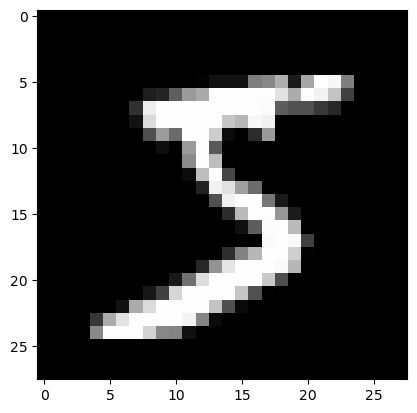

In [3]:
img, label = dataset[0]
plt.imshow(img[0], cmap='gray')

# 2. Model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
d_hidden = 30

class Autoencoder(nn.Module):
    def __init__(self, d=d_hidden):
        super().__init__()
        self.d = d
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, self.d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        hidden = self.encoder(x)
        x = self.decoder(hidden)
        return hidden, x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

# 3. Training

In [5]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1) # [batch_size, 28*28]

        # forward
        hidden,output = model(img)
        loss = criterion(output, img)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    # display_images(None, output)

epoch [1/20], loss:0.1975
epoch [2/20], loss:0.1402
epoch [3/20], loss:0.1141
epoch [4/20], loss:0.1076
epoch [5/20], loss:0.0978
epoch [6/20], loss:0.0832
epoch [7/20], loss:0.0862
epoch [8/20], loss:0.0834
epoch [9/20], loss:0.0800
epoch [10/20], loss:0.0743
epoch [11/20], loss:0.0716
epoch [12/20], loss:0.0739
epoch [13/20], loss:0.0697
epoch [14/20], loss:0.0624
epoch [15/20], loss:0.0690
epoch [16/20], loss:0.0616
epoch [17/20], loss:0.0611
epoch [18/20], loss:0.0575
epoch [19/20], loss:0.0575
epoch [20/20], loss:0.0598


# 4. Visualize the hidden vectors

In [6]:
with torch.no_grad():
    hidden_vectors = []
    labels = []
    for data in dataloader:
        img, lable = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        hidden,output = model(img)
        hidden_vectors.append(hidden)
        labels.append(lable)

In [7]:
hidden_vectors = torch.cat(hidden_vectors, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy().reshape(-1, 1)
print(hidden_vectors.shape, labels.shape)

(60000, 30) (60000, 1)


In [8]:
from sklearn.manifold import TSNE
embedded_vectors = TSNE(n_components=2).fit_transform(hidden_vectors[:1000,:])
print(embedded_vectors.shape)

(1000, 2)


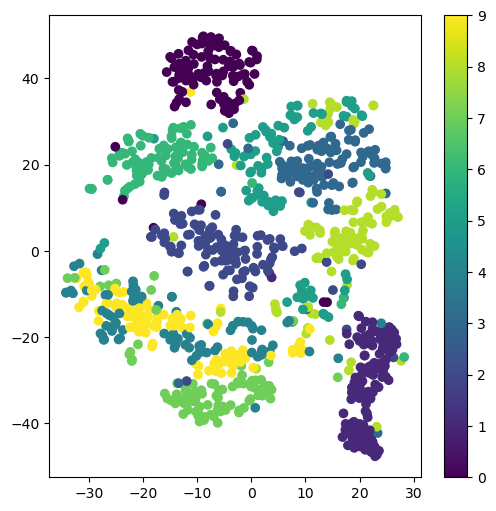

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(embedded_vectors[:, 0], embedded_vectors[:, 1], c=labels[:1000,:],cmap='viridis')
plt.colorbar()
plt.show()